# Carregar as bibliotecas

In [ ]:
import numpy as np
from skimage import io, data, filters, util, color, transform, exposure, measure
from skimage.util import img_as_float, img_as_uint, img_as_ubyte
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, svm
from sklearn.model_selection import train_test_split
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
from torchvision import datasets

## Carregar base MNIST para classificar usando Rede Neural

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform = transforms.ToTensor(),
    download=True
)

In [ ]:
print(test_dataset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()


## Datalaloader usada para criar batches durante o treino

In [ ]:
# Data loader
# Util pq cria automáticamente batches durante o treino
# além de embaralhar os dados
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True) 
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False) 

batch de dados: torch.Size([128, 1, 28, 28])
batch de etiquetas: torch.Size([128])


TypeError: ignored

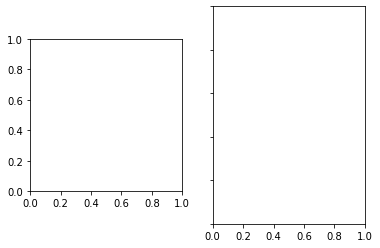

In [ ]:
# verificação do funcionamento do dataloader
for x, y in train_loader:
    print(f'batch de dados: {x.shape}')
    print(f'batch de etiquetas: {y.shape}')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    ax1.imshow(np.transpose(x[0].numpy(), (1,2,0)), cmap = 'gray')
#    ax2.imshow(np.transpose(x[0].numpy(), (1,2,0)), cmap = 'gray')
    ax1.imshow(x[0].numpy()[-1,:,:], cmap = 'gray')
    ax2.imshow(x[1].numpy()[-1,:,:], cmap = 'gray')
    break

## Criando uma CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU(),            
        )
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*2*2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )
    
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1) # nn.Flatten()
        out = self.dense_layers(out)
        return out

In [ ]:
# instanciar o modelo
K = 10
model = CNN(K)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# Loss para varias classes
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.Adagrad( model.parameters() )

In [ ]:
def fit(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
 
            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

In [ ]:
train_losses, test_losses = fit(model, criterion, optimizer, train_loader, test_loader, epochs = 10)

Epoch 1/10 Train Loss: 0.2731 Test Loss: 0.08601658556852018 Duracao: 0:00:28.529350
Epoch 2/10 Train Loss: 0.0933 Test Loss: 0.06873175131357452 Duracao: 0:00:30.343916
Epoch 3/10 Train Loss: 0.0740 Test Loss: 0.046915191272126296 Duracao: 0:00:30.813796
Epoch 4/10 Train Loss: 0.0618 Test Loss: 0.04360025023538295 Duracao: 0:00:30.080743
Epoch 5/10 Train Loss: 0.0528 Test Loss: 0.04115730649246421 Duracao: 0:00:30.233690
Epoch 6/10 Train Loss: 0.0489 Test Loss: 0.03788833688322714 Duracao: 0:00:27.851389
Epoch 7/10 Train Loss: 0.0428 Test Loss: 0.03634664339206441 Duracao: 0:00:28.071393
Epoch 8/10 Train Loss: 0.0398 Test Loss: 0.03576797703807861 Duracao: 0:00:27.215489
Epoch 9/10 Train Loss: 0.0366 Test Loss: 0.03483524420355739 Duracao: 0:00:27.356698
Epoch 10/10 Train Loss: 0.0348 Test Loss: 0.033135420776339235 Duracao: 0:00:27.331974


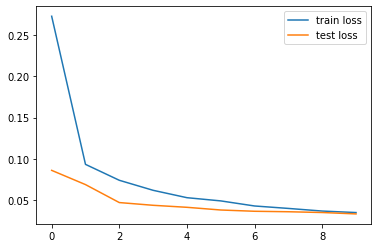

In [ ]:
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [ ]:
def predict_module(model, data_loader):
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions)
        true_labels = np.append(true_labels, targets)

    return predicted, true_labels
    


In [ ]:
predicted, true_labels = predict_module(model, test_loader)

In [ ]:
def matriz_confusao(true_labels, predicted):
    m = metrics.confusion_matrix(true_labels, predicted) 
    tot = np.sum(m, axis=1, keepdims=True) 

    m_porc = m/tot
    m_porc_str = np.array2string(m_porc, formatter={'float_kind':lambda x: "%.2f" % x})
    print( m_porc_str )

    np.set_printoptions(precision=2, suppress = True)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m, display_labels=[0,1,2,3,4,5,6,7,8,9])
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)
    plt.show()

[[0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.99 0.00 0.00 0.00 0.00 0.01 0.00 0.00]
 [0.00 0.00 0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.01 0.00 0.98 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.99 0.00 0.00 0.00]
 [0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.99 0.00 0.00]
 [0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.99 0.00]
 [0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.98]]


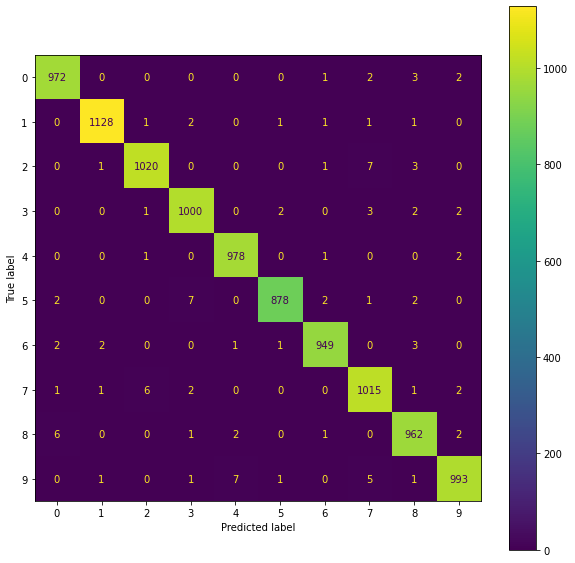

In [ ]:
matriz_confusao(true_labels, predicted) 

## Questão 1 
Modifique o número de camadas